In [ ]:
# Mount drive"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch import Tensor
from torch.utils.data import DataLoader
from numpy.random import random
import torch.nn.functional as F
from nltk.translate.gleu_score import sentence_gleu
from torch.utils.data import Dataset, DataLoader

In [ ]:
VOCAB_PATH='/content/drive/MyDrive/CS4248NLP/vocab.txt'
ENCODING_PATH = '/content/drive/MyDrive/CS4248NLP/bert_encoded_train_dataset.csv'

In [ ]:
use_cuda = torch.cuda.is_available()

# Use this line below to enforce the use of the CPU
#use_cuda = False

DEVICE = torch.device("cuda:0" if use_cuda else "cpu")

print("Available device: {}".format(DEVICE))

Available device: cuda:0


In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer(vocab_file=VOCAB_PATH)

In [ ]:
tokenizer

BertTokenizer(name_or_path='', vocab_size=28996, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
# Transformer model reference from Section 4.2 - Transformer Machine Translation.ipynb

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model = bert_model.to(DEVICE)
for param in bert_model.parameters():
    param.requires_grad = False
# emb_size = bert_model.config.hidden_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.emb_size = emb_size

    def forward(self, tokens: Tensor, tokens_mask: Tensor):
      bert_attention_mask = ~tokens_mask
      bert_attention_mask = bert_attention_mask.long()

      with torch.no_grad():
          outputs = bert_model(tokens.T, attention_mask=bert_attention_mask)

      last_hidden_states = outputs.last_hidden_state
      return (last_hidden_states * math.sqrt(self.emb_size)).transpose(0, 1)

In [ ]:
input_df = pd.read_csv(ENCODING_PATH, header=None)

In [ ]:
input_df

,0,1
0,101 1422 1411 1110 170 5143 2060 1331 1114 146...,101 1422 1411 1110 170 5143 118 6956 1331 1114...
1,101 1135 1144 170 1344 3476 1416 1272 1157 135...,101 1135 1144 170 1344 118 3476 1416 1272 1104...
2,101 2711 1104 1122 1110 1126 3924 1331 117 117...,101 1966 1122 1110 1126 3924 1331 117 1175 113...
3,101 146 18029 5807 1103 8246 3521 1107 1103 17...,101 146 18029 5807 1103 8246 3521 1107 1103 20...
4,101 11415 15297 1132 1304 1887 1105 1211 1104 ...,101 11415 15297 1132 1304 1887 1105 1211 1104 ...
...,...,...
22680,101 7013 5789 1138 1510 1151 3468 1112 1103 15...,101 7013 5789 1138 1510 1151 3468 1112 1103 15...
22681,101 1247 1180 1129 170 1974 1104 3672 117 1176...,101 1247 1180 1129 170 1974 1104 3672 117 1176...
22682,101 1130 1103 1269 1236 170 3318 3677 1144 110...,101 1130 1103 1269 1236 117 170 3318 3677 1144...
22683,101 6589 19574 1110 1304 1696 131 8582 2993 17...,101 6589 117 19574 1110 1304 1696 131 8582 299...


In [ ]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Split the string by spaces and convert to integers
        src = [int(num) for num in row[0].split()]
        tgt = [int(num) for num in row[1].split()]

        src = torch.tensor(src, dtype=torch.long)
        tgt = torch.tensor(tgt, dtype=torch.long)
        return src, tgt

input_dataset = CustomDataset(input_df)

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
input_dataset = CustomDataset(input_df)
train_size = int(0.9 * len(input_dataset))
test_size = len(input_dataset) - train_size

train_dataset, test_dataset = random_split(input_dataset, [train_size, test_size])

In [ ]:
len(train_dataset.indices)

20416

In [ ]:
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True ,padding_value=tokenizer.convert_tokens_to_ids(['[PAD]'])[0])
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=tokenizer.convert_tokens_to_ids(['[PAD]'])[0])
    return src_batch, tgt_batch

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
import math
from tqdm import tqdm
from typing import Iterable, List
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src, src_padding_mask))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg, tgt_padding_mask))

        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_padding_mask: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src, src_padding_mask)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_padding_mask: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt, tgt_padding_mask)), memory, tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.bool()


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == tokenizer.convert_tokens_to_ids(['[PAD]'])[0]).transpose(0, 1)
    tgt_padding_mask = (tgt == tokenizer.convert_tokens_to_ids(['[PAD]'])[0]).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
# src.shape

In [ ]:
def train_epoch(model, optimizer, criterion):
    model.train()
    losses = 0
    for src, tgt in tqdm(train_loader, total=len(list(train_loader))):

        src = src.T.to(DEVICE)
        tgt = tgt.T.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()
        tgt_out = tgt[1:, :]

        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_loader))


def evaluate(model):
    model.eval()
    losses = 0


    for src, tgt in tqdm(test_loader, total=len(list(test_loader))):
        src = src.T.to(DEVICE)
        tgt = tgt.T.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]

        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(test_loader))


In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = tokenizer.vocab_size
TGT_VOCAB_SIZE = tokenizer.vocab_size
EMB_SIZE = 768
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

# Create model
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

# Initialize weights
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Move model to device (ideally GPU, otherwise CPU)
transformer = transformer.to(DEVICE)

# Define loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(['[PAD]'])[0])

# Define optimizer
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
NUM_EPOCHS = 20

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, criterion)
    end_time = timer()
    torch.save(transformer, '/content/drive/MyDrive/CS4248NLP/transformer_model/model.pt')
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time (total) = {(end_time - start_time):.3f}s"))
    # val_loss = evaluate(transformer)
    # print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time (total) = {(end_time - start_time):.3f}s"))
    # print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time (total) = {(end_time - start_time):.3f}s"))

100%|██████████| 36/36 [00:08<00:00,  4.45it/s]


Epoch: 1, Train loss: 6.043, Val loss: 4.691, Epoch time (total) = 106.807s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 2, Train loss: 4.297, Val loss: 3.701, Epoch time (total) = 104.548s


100%|██████████| 36/36 [00:08<00:00,  4.45it/s]


Epoch: 3, Train loss: 3.536, Val loss: 3.136, Epoch time (total) = 105.121s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 4, Train loss: 3.035, Val loss: 2.744, Epoch time (total) = 103.689s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 5, Train loss: 2.670, Val loss: 2.468, Epoch time (total) = 105.189s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 6, Train loss: 2.380, Val loss: 2.255, Epoch time (total) = 104.541s


100%|██████████| 36/36 [00:08<00:00,  4.45it/s]


Epoch: 7, Train loss: 2.139, Val loss: 2.066, Epoch time (total) = 104.391s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 8, Train loss: 1.922, Val loss: 1.900, Epoch time (total) = 105.515s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 9, Train loss: 1.723, Val loss: 1.747, Epoch time (total) = 104.528s


100%|██████████| 36/36 [00:08<00:00,  4.47it/s]


Epoch: 10, Train loss: 1.529, Val loss: 1.563, Epoch time (total) = 104.264s


100%|██████████| 36/36 [00:08<00:00,  4.43it/s]


Epoch: 11, Train loss: 1.335, Val loss: 1.413, Epoch time (total) = 105.821s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 12, Train loss: 1.156, Val loss: 1.251, Epoch time (total) = 104.845s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 13, Train loss: 1.000, Val loss: 1.147, Epoch time (total) = 103.979s


100%|██████████| 36/36 [00:08<00:00,  4.44it/s]


Epoch: 14, Train loss: 0.867, Val loss: 1.069, Epoch time (total) = 104.780s


100%|██████████| 36/36 [00:08<00:00,  4.45it/s]


Epoch: 15, Train loss: 0.756, Val loss: 0.991, Epoch time (total) = 104.210s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 16, Train loss: 0.658, Val loss: 0.923, Epoch time (total) = 104.892s


100%|██████████| 36/36 [00:08<00:00,  4.44it/s]


Epoch: 17, Train loss: 0.576, Val loss: 0.880, Epoch time (total) = 104.064s


100%|██████████| 36/36 [00:08<00:00,  4.47it/s]


Epoch: 18, Train loss: 0.506, Val loss: 0.833, Epoch time (total) = 104.904s


100%|██████████| 36/36 [00:08<00:00,  4.46it/s]


Epoch: 19, Train loss: 0.442, Val loss: 0.805, Epoch time (total) = 102.534s


100%|██████████| 36/36 [00:08<00:00,  4.45it/s]


Epoch: 20, Train loss: 0.388, Val loss: 0.791, Epoch time (total) = 104.266s


In [ ]:
import torch
model = torch.load('/content/drive/MyDrive/CS4248NLP/transformer_model/model.pt', map_location=torch.device(DEVICE))
model.eval()

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [ ]:
model

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [ ]:
# Method to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    src_padding_mask = (src == tokenizer.convert_tokens_to_ids(['[PAD]'])[0]).transpose(0, 1)
    # tgt_padding_mask = (tgt == tokenizer.convert_tokens_to_ids(['[PAD]'])[0]).transpose(0, 1)

    memory = model.encode(src, src_padding_mask, src_mask)
    # print(memory)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
        tgt_padding_mask = (ys == tokenizer.convert_tokens_to_ids(['[PAD]'])[0]).transpose(0, 1)
        # print(tgt_padding_mask)
        out = model.decode(ys, memory, tgt_padding_mask, tgt_mask)
        # print('out : ', out.shape)
        out = out.transpose(0, 1)
        # print('out : ', out.shape)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        # print(next_word)

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == tokenizer.convert_tokens_to_ids('[SEP]'):
            break
    return ys


# Actual method to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()

    src = [tokenizer.convert_tokens_to_ids(word) for word in src_sentence.split()]
    src = torch.tensor(src, dtype=torch.long).view(-1, 1)
    # print(src.shape)
    # src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)

    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model, src, src_mask, max_len=num_tokens+5, start_symbol=tokenizer.convert_tokens_to_ids('[CLS]')).flatten()
    # return tgt_tokens
    # print(tgt_tokens)
    return " ".join(tokenizer.convert_ids_to_tokens(list(tgt_tokens.cpu().numpy()))).replace("[CLS]", "").replace("[SEP]", "")


In [ ]:
translate(model, "what are you doing")

' What '

In [ ]:
translate(model, "The building has two changing rooms for men and women .")

' The for for for for for for for for for for for for for for'

In [ ]:
translate(model, "The amount of talking done by the students was more that pleasing .")

' The was The The The The The The The The The The The The The The The'

In [ ]:
translate(model, "I completely agree with you , maybe each word you say .")

' I words each each each each each each each each each each each per , per'

In [ ]:
translate(model, 'Despite of it is an industrial city , there are many shops and department stores .')

' The after after after after after after after after after after after after after after after after after after after'

In [ ]:
model_size = 768

In [ ]:
batch_size, seq_len = 1, 50

random_batch_embedded = rand_tensor = torch.rand((batch_size, seq_len, model_size)).to(DEVICE)

In [ ]:
model.positional_encoding

PositionalEncoding(
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
random_batch_pos_encoded = model.positional_encoding(random_batch_embedded)

print(random_batch_pos_encoded.squeeze(0).shape)

torch.Size([50, 768])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

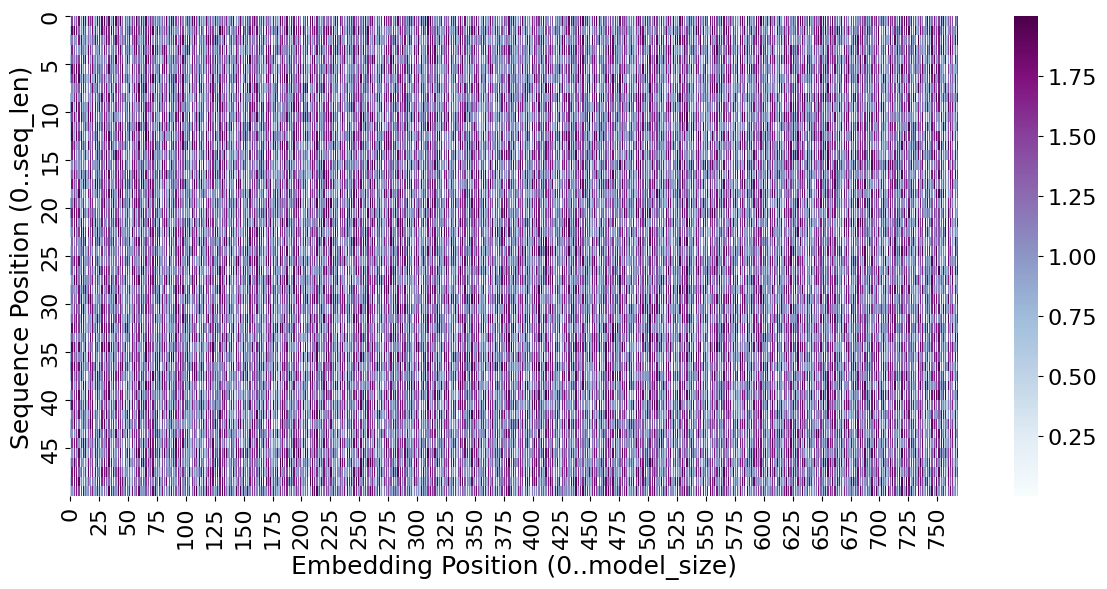

In [ ]:
fig = plt.figure(figsize=(12,6))
r = sns.heatmap(random_batch_pos_encoded.squeeze(0).to('cpu'), cmap='BuPu')
plt.xticks(range(0, model_size, 25), range(0, model_size, 25))
plt.yticks(range(0, seq_len, 5), range(0, seq_len, 5))
# Change the fontsize of minor ticks label
plt.gca().tick_params(axis='both', which='major', labelsize=16)
plt.gca().tick_params(axis='both', which='minor', labelsize=8)
cbar = r.collections[0].colorbar
# Set the label size to 20
cbar.ax.tick_params(labelsize=16)
plt.xlabel("Embedding Position (0..model_size)", fontsize=18)
plt.ylabel("Sequence Position (0..seq_len)", fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
import torch


def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def beam_search_decode(model, src, src_mask, max_len, start_symbol, beam_size=3):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    src_padding_mask = (src == tokenizer.convert_tokens_to_ids(['[PAD]'])[0]).transpose(0, 1)

    memory = model.encode(src, src_padding_mask, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)

    beams = [(0, ys)]

    for _ in range(max_len-1):
        all_candidates = []
        for prob, seq in beams:
            if seq[-1, 0] == tokenizer.convert_tokens_to_ids('[SEP]'):
                all_candidates.append((prob, seq))
                continue

            tgt_mask = generate_square_subsequent_mask(seq.size(0)).type(torch.bool).to(DEVICE)
            tgt_padding_mask = (seq == tokenizer.convert_tokens_to_ids('[PAD]')).transpose(0, 1)
            out = model.decode(seq, memory, tgt_padding_mask, tgt_mask)
            out_prob = model.generator(out[:, -1])


            for idx in range(out_prob.size(0)):
                single_out_prob = out_prob[idx].squeeze()
                assert single_out_prob.dim() == 1, f"Expected single_out_prob to be 1D, got shape {single_out_prob.shape}"
                top_probs, top_ix = torch.topk(single_out_prob, beam_size)

                for i in range(beam_size):
                    next_prob = top_probs[i].item()
                    next_word = top_ix[i].item()
                    next_seq = torch.cat([seq, torch.ones(1, 1).type_as(seq).fill_(next_word)], dim=0)
                    new_prob = prob + next_prob
                    all_candidates.append((new_prob, next_seq))

        all_candidates.sort(reverse=True, key=lambda x: x[0])
        beams = all_candidates[:beam_size]

    return beams[0][1]

def translate_beam(model: torch.nn.Module, src_sentence: str, beam_size=3):
    model.eval()

    src = [tokenizer.convert_tokens_to_ids(word) for word in src_sentence.split()]
    src = torch.tensor(src, dtype=torch.long).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    tgt_tokens = beam_search_decode(model, src, src_mask, max_len=num_tokens+5, start_symbol=tokenizer.convert_tokens_to_ids('[CLS]'), beam_size=beam_size).flatten()
    return " ".join(tokenizer.convert_ids_to_tokens(list(tgt_tokens.cpu().numpy()))).replace("[CLS]", "").replace("[SEP]", "")



In [ ]:
translate_beam(model, "The building has two changing rooms for men and women .")

' The for for for for for for for for for for for for for for'